# Coursera Capstone Project

## NOTEBOOK



### Upload Libraries Required

In [1]:
import numpy as np # library to handle data in a vectorized manner
import time
import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe


!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
!pip 
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library
import folium # map rendering library
from folium import plugins

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

import seaborn as sns

# import k-means from clustering stage
from sklearn.cluster import KMeans



print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - geopy


The following NEW packages will be INSTALLED:

  geographiclib      conda-forge/noarch::geographiclib-1.50-py_0
  geopy              conda-forge/noarch::geopy-1.22.0-pyh9f0ad1d_0


Preparing transaction: done
Verifying transaction: done
Executing transaction: done

Usage:   
  pip <command> [options]

Commands:
  install                     Install packages.
  download                    Download packages.
  uninstall                   Uninstall packages.
  freeze                      Output installed packages in requirements format.
  list                        List installed packages.
  show                        Show information about installed packages.
  check                       Verify installed packages have compatible dependencies.
  config                      Manage local and global configuration.
  search                      S

In [2]:
# Shenton Way, District 01, Singapore
address = 'Mccallum Street, Singapore'
geolocator = Nominatim()
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Singapore home are {}, {}.'.format(latitude, longitude))

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Using Nominatim with the default "geopy/1.22.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  This is separate from the ipykernel package so we can avoid doing imports until


The geograpical coordinate of Singapore home are 1.2784801, 103.8493717.


In [3]:
neighborhood_latitude=1.2792655
neighborhood_longitude=103.8480938

## Dial FourSquare to find venues around current residence in Singapore

In [4]:
# @hidden_cell
CLIENT_ID = 'NJOFG4W5BQGMTK4NY2FWUOXBH1UTD4NRPI55YT5UEVJKOZEW' # your Foursquare ID
CLIENT_SECRET = 'DXLXXD3W1WXHV5V4KJRXYX5UTI00AA3FL4143VJFYVRMTGU2' # your Foursquare Secret
VERSION = '20180604' # Foursquare API version

#print('Your credentails:')
#print('CLIENT_ID: ' + CLIENT_ID)
#print('CLIENT_SECRET:' + CLIENT_SECRET)

In [7]:
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # define radius
# create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
url # display URL

'https://api.foursquare.com/v2/venues/explore?&client_id=NJOFG4W5BQGMTK4NY2FWUOXBH1UTD4NRPI55YT5UEVJKOZEW&client_secret=DXLXXD3W1WXHV5V4KJRXYX5UTI00AA3FL4143VJFYVRMTGU2&v=20180604&ll=1.2792655,103.8480938&radius=500&limit=100'

In [8]:
# results display is hidden for report simplification 
results = requests.get(url).json()
#results 

#### function that extracts the category of the venue - borrow from the Foursquare lab.

In [9]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [10]:
venues = results['response']['groups'][0]['items']
SGnearby_venues = json_normalize(venues) # flatten JSON
# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
SGnearby_venues =SGnearby_venues.loc[:, filtered_columns]
# filter the category for each row
SGnearby_venues['venue.categories'] = SGnearby_venues.apply(get_category_type, axis=1)
# clean columns
SGnearby_venues.columns = [col.split(".")[-1] for col in SGnearby_venues.columns]

SGnearby_venues.shape

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  


(100, 4)

In [11]:
# Venues near current Singapore residence place
SGnearby_venues.head(10)

,name,categories,lat,lng
0,Napoleon Food & Wine Bar,Wine Bar,1.279925,103.847333
1,Native,Cocktail Bar,1.280135,103.846844
2,Freehouse,Beer Garden,1.281254,103.848513
3,Sofitel So Singapore,Hotel,1.280017,103.849813
4,Park Bench Deli,Deli / Bodega,1.279872,103.847287
5,Pepper Bowl,Asian Restaurant,1.279371,103.846710
6,Meat Smith,Southern / Soul Food Restaurant,1.280205,103.847410
7,Mellower Coffee,Café,1.277814,103.848188
8,PS.Cafe,Café,1.280468,103.846264
9,Anglo Indian Cafe & Bar,Indian Restaurant,1.279084,103.850127


## Map of Singapore residence place with venues in Neighborhood - for reference

In [12]:
latitude=1.2792655
longitude=103.8480938
# create map of Singapore place  using latitude and longitude values
map_sg = folium.Map(location=[latitude, longitude], zoom_start=18)
# add markers to map
for lat, lng, label in zip(SGnearby_venues['lat'], SGnearby_venues['lng'], SGnearby_venues['name']):
    label = folium.Popup(label, parse_html=True)
    folium.RegularPolygonMarker(
        [lat, lng],
        number_of_sides=30,
        radius=7,
        popup=label,
        color='blue',
        fill_color='#0f0f0f',
        fill_opacity=0.6,
    ).add_to(map_sg)  
    
map_sg

# MANHATTAN NEIGHBORHOODS - DATA AND MAPPING 
## Cluster neighborhood data was produced with Foursquare during course lab work. A csv file was produced containing the neighborhoods around the 40 Boroughs. Now, the csv file is just read for convenience and consolidation of report.

In [18]:
# Read csv file with clustered neighborhoods with geodata
manhattan_data  = pd.read_csv('mh_neigh_data.csv') 
manhattan_data.head()

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels
0,Manhattan,Marble Hill,40.876551,-73.910660,2
1,Manhattan,Chinatown,40.715618,-73.994279,2
2,Manhattan,Washington Heights,40.851903,-73.936900,4
3,Manhattan,Inwood,40.867684,-73.921210,3
4,Manhattan,Hamilton Heights,40.823604,-73.949688,0


In [19]:
manhattan_data.tail()

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels
35,Manhattan,Turtle Bay,40.752042,-73.967708,3
36,Manhattan,Tudor City,40.746917,-73.971219,3
37,Manhattan,Stuyvesant Town,40.731000,-73.974052,4
38,Manhattan,Flatiron,40.739673,-73.990947,3
39,Manhattan,Hudson Yards,40.756658,-74.000111,2


# Manhattan Borough neighborhoods - data with top 10 clustered venues


In [20]:
manhattan_merged = pd.read_csv('manhattan_merged.csv')
manhattan_merged.head()

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Manhattan,Marble Hill,40.876551,-73.910660,2,Coffee Shop,Discount Store,Yoga Studio,Steakhouse,Supplement Shop,Tennis Stadium,Shoe Store,Gym,Bank,Seafood Restaurant
1,Manhattan,Chinatown,40.715618,-73.994279,2,Chinese Restaurant,Cocktail Bar,Dim Sum Restaurant,American Restaurant,Vietnamese Restaurant,Salon / Barbershop,Noodle House,Bakery,Bubble Tea Shop,Ice Cream Shop
2,Manhattan,Washington Heights,40.851903,-73.936900,4,Café,Bakery,Mobile Phone Shop,Pizza Place,Sandwich Place,Park,Gym,Latin American Restaurant,Tapas Restaurant,Mexican Restaurant
3,Manhattan,Inwood,40.867684,-73.921210,3,Mexican Restaurant,Lounge,Pizza Place,Café,Wine Bar,Bakery,American Restaurant,Park,Frozen Yogurt Shop,Spanish Restaurant
4,Manhattan,Hamilton Heights,40.823604,-73.949688,0,Mexican Restaurant,Coffee Shop,Café,Deli / Bodega,Pizza Place,Liquor Store,Indian Restaurant,Sushi Restaurant,Sandwich Place,Yoga Studio


# Map of Manhattan neighborhoods with top 10 clustered venues

## popus   allow to identify each neighborhood and the cluster of venues around it in order to proceed to examine in more detail in the next cell

In [21]:
# create map of Manhattan using latitude and longitude values from Nominatim
latitude= 40.7308619
longitude= -73.9871558 

kclusters=5
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=13)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(manhattan_merged['Latitude'], manhattan_merged['Longitude'], manhattan_merged['Neighborhood'], manhattan_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=20,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
  # add markers for rental places to map
for lat, lng, label in zip(manhattan_data['Latitude'], manhattan_data['Longitude'], manhattan_data['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_clusters)    
    
       
map_clusters

## Examine a paticular Cluster - print venues

### After examining several cluster data , I concluded that cluster # 2 resembles closer the Singapore place, therefore providing guidance as to where to look for the future apartment .
### Assign a value to 'kk' to explore a given cluster.

In [22]:
## kk is the cluster number to explore
kk = 2
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == kk, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Marble Hill,Coffee Shop,Discount Store,Yoga Studio,Steakhouse,Supplement Shop,Tennis Stadium,Shoe Store,Gym,Bank,Seafood Restaurant
1,Chinatown,Chinese Restaurant,Cocktail Bar,Dim Sum Restaurant,American Restaurant,Vietnamese Restaurant,Salon / Barbershop,Noodle House,Bakery,Bubble Tea Shop,Ice Cream Shop
6,Central Harlem,African Restaurant,Seafood Restaurant,French Restaurant,American Restaurant,Cosmetics Shop,Chinese Restaurant,Event Space,Liquor Store,Beer Bar,Gym / Fitness Center
9,Yorkville,Coffee Shop,Gym,Bar,Italian Restaurant,Sushi Restaurant,Pizza Place,Mexican Restaurant,Deli / Bodega,Japanese Restaurant,Pub
14,Clinton,Theater,Italian Restaurant,Coffee Shop,American Restaurant,Gym / Fitness Center,Hotel,Wine Shop,Spa,Gym,Indie Theater
23,Soho,Clothing Store,Boutique,Women's Store,Shoe Store,Men's Store,Furniture / Home Store,Italian Restaurant,Mediterranean Restaurant,Art Gallery,Design Studio
26,Morningside Heights,Coffee Shop,American Restaurant,Park,Bookstore,Pizza Place,Sandwich Place,Burger Joint,Café,Deli / Bodega,Tennis Court
34,Sutton Place,Gym / Fitness Center,Italian Restaurant,Furniture / Home Store,Indian Restaurant,Dessert Shop,American Restaurant,Bakery,Juice Bar,Boutique,Sushi Restaurant
39,Hudson Yards,Coffee Shop,Italian Restaurant,Hotel,Theater,American Restaurant,Café,Gym / Fitness Center,Thai Restaurant,Restaurant,Gym


# Map of Manhattan places for rent

## Several Manhattan real estate webs were webscrapped to collect rental data, as mentioned in section 2.0 . The resut was summarized in a csv file for direct reading, in order to consolidate the proces. 
### The initial data for 144 apartment did not have the latitude and longitude data (NaN) but the information was established in the following cell using an algorythm and Nominatim.

In [23]:
# csv files with rental places with basic data but still wihtout geodata ( latitude and longitude)
# pd.read_csv(' le.csv', header=None, nrows=5)
mh_rent=pd.read_csv('MH_flats_price.csv')
mh_rent.head()

,Address,Area,Price_per_ft2,Rooms,Area-ft2,Rent_Price,Lat,Long
0,West 105th Street,Upper West Side,2.94,5.0,3400,10000,NaN,NaN
1,East 97th Street,Upper East Side,3.57,3.0,2100,7500,NaN,NaN
2,West 105th Street,Upper West Side,1.89,4.0,2800,5300,NaN,NaN
3,CARMINE ST.,West Village,3.03,2.0,1650,5000,NaN,NaN
4,171 W 23RD ST.,Chelsea,3.45,2.0,1450,5000,NaN,NaN


In [24]:
mh_rent.tail()

,Address,Area,Price_per_ft2,Rooms,Area-ft2,Rent_Price,Lat,Long
139,200 East 72nd Street,Rental in Lenox Hill,5.15,3.0,1700,8750,NaN,NaN
140,50 Murray Street,No fee rental in Tribeca,7.11,2.0,1223,8700,NaN,NaN
141,300 East 56th Street,No fee rental in Midtown East,3.87,3.0,2100,8118,NaN,NaN
142,1930 Broadway,No fee rental in Central Park West,5.06,2.0,1600,8095,NaN,NaN
143,33 West 9th Street,Rental in Greenwich Village,6.67,2.0,1500,10000,NaN,NaN


## Obtain geodata ( lat,long) for each rental place in Manhattan with Nominatim

### Data  was stored in a csv file for simplifaction report purposes and saving code processing time in future.

## This coding section was  'markedown' for the report because its execution takes few minutes . Terefore, the csv saved will be  be just read directly in the following cell.   

for n in range(len(mh_rent)):   
    address= mh_rent['Address'][n]
    address=(mh_rent['Address'][n]+ '  , '+' Manhattan NY ')
    geolocator = Nominatim()
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    mh_rent['Lat'][n]=latitude
    mh_rent['Long'][n]=longitude
    #print(n,latitude,longitude)
    time.sleep(2)

print('Geodata completed')
# save dataframe to csv file
mh_rent.to_csv('MH_rent_latlong.csv',index=False)
mh_rent.shape

In [26]:
mh_rent=pd.read_csv('MH_rent_latlong.csv')
mh_rent.head()

,Address,Area,Price_per_ft2,Rooms,Area-ft2,Rent_Price,Lat,Long
0,West 105th Street,Upper West Side,2.94,5.0,3400,10000,40.799771,-73.966213
1,East 97th Street,Upper East Side,3.57,3.0,2100,7500,40.788585,-73.955277
2,West 105th Street,Upper West Side,1.89,4.0,2800,5300,40.799771,-73.966213
3,CARMINE ST.,West Village,3.03,2.0,1650,5000,40.730523,-74.001873
4,171 W 23RD ST.,Chelsea,3.45,2.0,1450,5000,40.744118,-73.995299


In [27]:
mh_rent.tail()

,Address,Area,Price_per_ft2,Rooms,Area-ft2,Rent_Price,Lat,Long
139,200 East 72nd Street,Rental in Lenox Hill,5.15,3.0,1700,8750,40.769465,-73.960339
140,50 Murray Street,No fee rental in Tribeca,7.11,2.0,1223,8700,40.714051,-74.009608
141,300 East 56th Street,No fee rental in Midtown East,3.87,3.0,2100,8118,40.758216,-73.965190
142,1930 Broadway,No fee rental in Central Park West,5.06,2.0,1600,8095,40.772474,-73.981901
143,33 West 9th Street,Rental in Greenwich Village,6.67,2.0,1500,10000,40.733691,-73.997323


# Manhattan apartment rent price statistics
### A US 7000 Dollar per month rent is actually around the mean value - similar to Singapore! wow!

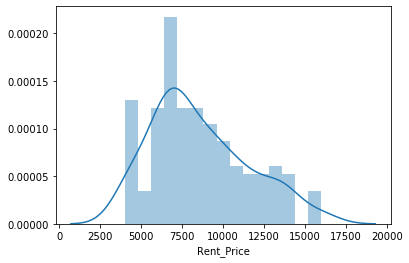

In [28]:
import seaborn as sns
sns.distplot(mh_rent['Rent_Price'],bins=15)

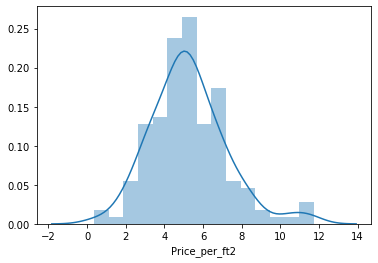

In [29]:
import seaborn as sns
sns.distplot(mh_rent['Price_per_ft2'],bins=15)

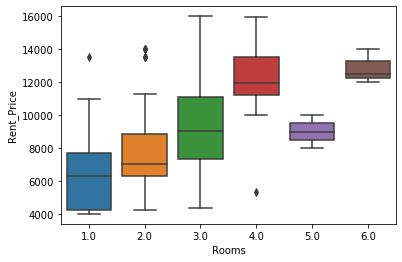

In [30]:
sns.boxplot(x='Rooms', y= 'Rent_Price', data=mh_rent)

# Map of Manhattan apartments for rent 
### The popups will indicate the address and the monthly price for rent thus making it convenient to select the target appartment with the price condition estipulated (max US7000 )

In [31]:
# create map of Manhattan using latitude and longitude values from Nominatim
latitude= 40.7308619
longitude= -73.9871558

map_manhattan_rent = folium.Map(location=[latitude, longitude], zoom_start=12.5)

# add markers to map
for lat, lng, label in zip(mh_rent['Lat'], mh_rent['Long'],'$ ' + mh_rent['Rent_Price'].astype(str)+ ',  '+ mh_rent['Address']):      
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=6,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_manhattan_rent) 
    

map_manhattan_rent

# Map of Manhattan showing the places for rent and the cluster of venues 
### Now, one can point to a rental place for price and address location information while knowing the cluster venues around it.
### This is an insightful way to explore rental possibilites

In [32]:
# create map of Manhattan using latitude and longitude values from Nominatim
latitude= 40.7308619
longitude= -73.9871558

# create map with clusters
kclusters=5
map_clusters2 = folium.Map(location=[latitude, longitude], zoom_start=13)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(manhattan_merged['Latitude'], manhattan_merged['Longitude'], manhattan_merged['Neighborhood'], manhattan_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=20,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters2)

# add markers to map for rental places
for lat, lng, label in zip(mh_rent['Lat'], mh_rent['Long'],'$ ' + mh_rent['Rent_Price'].astype(str)+ mh_rent['Address']):      
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=6,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_clusters2)  
    
    # Adds tool to the top right
from folium.plugins import MeasureControl
map_manhattan_rent.add_child(MeasureControl())

# FMeasurement ruler icon to establish distnces on map
from folium.plugins import FloatImage
url = ('https://media.licdn.com/mpr/mpr/shrinknp_100_100/AAEAAQAAAAAAAAlgAAAAJGE3OTA4YTdlLTkzZjUtNDFjYy1iZThlLWQ5OTNkYzlhNzM4OQ.jpg')
FloatImage(url, bottom=5, left=85).add_to(map_manhattan_rent)

map_clusters2


# Now one can explore a particular rental place and its venues in detail

## In the map above, examination of appartments with rental place below 7000/month is straightforwad while knowing the venues around it. 
## We could find an appartment with at the right price and in a location with desirable venues. The next step is to see if it is located near a subway metro station, in next cells work.

In [33]:
## kk is the cluster number to explore
kk = 3
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == kk, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,Inwood,Mexican Restaurant,Lounge,Pizza Place,Café,Wine Bar,Bakery,American Restaurant,Park,Frozen Yogurt Shop,Spanish Restaurant
5,Manhattanville,Deli / Bodega,Italian Restaurant,Seafood Restaurant,Mexican Restaurant,Sushi Restaurant,Beer Garden,Coffee Shop,Falafel Restaurant,Bike Trail,Other Nightlife
10,Lenox Hill,Sushi Restaurant,Italian Restaurant,Coffee Shop,Gym / Fitness Center,Pizza Place,Burger Joint,Deli / Bodega,Gym,Sporting Goods Shop,Thai Restaurant
12,Upper West Side,Italian Restaurant,Bar,Bakery,Vegetarian / Vegan Restaurant,Indian Restaurant,Coffee Shop,Cosmetics Shop,Wine Bar,Mexican Restaurant,Sushi Restaurant
16,Murray Hill,Sandwich Place,Hotel,Japanese Restaurant,Gym / Fitness Center,Coffee Shop,Salon / Barbershop,Burger Joint,French Restaurant,Bar,Italian Restaurant
17,Chelsea,Coffee Shop,Italian Restaurant,Ice Cream Shop,Bakery,Nightclub,Theater,Art Gallery,Seafood Restaurant,American Restaurant,Hotel
18,Greenwich Village,Italian Restaurant,Sushi Restaurant,French Restaurant,Clothing Store,Chinese Restaurant,Café,Indian Restaurant,Bakery,Seafood Restaurant,Electronics Store
27,Gramercy,Italian Restaurant,Restaurant,Thrift / Vintage Store,Cocktail Bar,Bagel Shop,Coffee Shop,Pizza Place,Mexican Restaurant,Grocery Store,Wine Shop
29,Financial District,Coffee Shop,Hotel,Gym,Wine Shop,Steakhouse,Bar,Italian Restaurant,Pizza Place,Park,Gym / Fitness Center
31,Noho,Italian Restaurant,French Restaurant,Cocktail Bar,Gift Shop,Bookstore,Grocery Store,Mexican Restaurant,Hotel,Sushi Restaurant,Coffee Shop


# Mapping Manhattan Subway locations
### Manhattan subway metro locations ( address) was obtained from webscrapping sites such as Wikipedia, Google and NY Metro Transit.  For simplification, a csv file was produced from the 'numbers' (Apple excel ) so that the reading of this file is the starting point here.

### The geodata will be obtain via Nominatim using the algorythm below.

In [35]:
# A csv file summarized the subway station and the addresses for next step to determine geodata
mh=pd.read_csv('NYC_subway_list.csv')
mh.head()

,sub_station,sub_address
0,Dyckman Street Subway Station,"170 Nagle Ave, New York, NY 10034, USA"
1,57 Street Subway Station,"New York, NY 10106, USA"
2,Broad St,"New York, NY 10005, USA"
3,175 Street Station,"807 W 177th St, New York, NY 10033, USA"
4,5 Av and 53 St,"New York, NY 10022, USA"


### Add colums labeled 'lat' and 'long' to be filled with geodata

In [36]:
#  Add columns 'lat'  and 'long' to mh dataframe - with random temporary numbers to get started
sLength = len(mh['sub_station'])
lat = pd.Series(np.random.randn(sLength))
long=pd.Series(np.random.randn(sLength))
mh = mh.assign(lat=lat.values)
mh = mh.assign(long=long.values)

## Algorythm to find latitude and longitud for each subway metro station and add them to dataframe
### This coding has been 'Markdown' just to simplify the file report, and the csv file will be read in cell below.

for n in range(len(mh)):
    address= mh['sub_address'][n]
    geolocator = Nominatim()
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    mh['lat'][n]=latitude
    mh['long'][n]=longitude
    #print(n,latitude,longitude)
    time.sleep(2)

print('Geodata completed')
# save dataframe to csv file
mh.to_csv('MH_subway.csv',index=False)
mh.shape

## Read csv file that produced the subway stations list with geodata

In [38]:
mh=pd.read_csv('MH_subway.csv')
print(mh.shape)
mh.head()

(76, 4)


,sub_station,sub_address,lat,long
0,Dyckman Street Subway Station,"170 Nagle Ave, New York, NY 10034, USA",40.861857,-73.924509
1,57 Street Subway Station,"New York, NY 10106, USA",40.764250,-73.954525
2,Broad St,"New York, NY 10005, USA",40.730862,-73.987156
3,175 Street Station,"807 W 177th St, New York, NY 10033, USA",40.847991,-73.939785
4,5 Av and 53 St,"New York, NY 10022, USA",40.764250,-73.954525


In [39]:
# removing duplicate rows and creating new set mhsub1
mhsub1=mh.drop_duplicates(subset=['lat','long'], keep="last").reset_index(drop=True)
mhsub1.shape

(22, 4)

In [40]:
mhsub1.tail()

,sub_station,sub_address,lat,long
17,190 Street Subway Station,"Bennett Ave, New York, NY 10040, USA",40.858113,-73.932983
18,59 St-Lexington Av Station,"E 60th St, New York, NY 10065, USA",40.762259,-73.966271
19,57 Street Station,"New York, NY 10019, United States",40.764250,-73.954525
20,14 Street / 8 Av,"New York, NY 10014, United States",40.730862,-73.987156
21,MTA New York City,"525 11th Ave, New York, NY 10018, USA",40.759809,-73.999282


## MAP of Manhattan showing the location of subway stations

In [34]:
# map subway stations 
# create map of Manhattan using latitude and longitude values obtain previoulsy via Moninatim geolocator
latitude=40.7308619
longitude=-73.9871558

map_mhsub1 = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers of subway locations to map
for lat, lng, label in zip(mhsub1['lat'], mhsub1['long'],  mhsub1['sub_station'].astype(str) ):
    label = folium.Popup(label, parse_html=True)
    folium.RegularPolygonMarker(
        [lat, lng],
        number_of_sides=6,
        radius=6,
        popup=label,
        color='red',
        fill_color='red',
        fill_opacity=2.5,
    ).add_to(map_mhsub1) 
map_mhsub1

# Map of Manhattan showing places for rent and the subway locations nearby

## Now, we can visualize the desirable rental places and their nearest subway station. Popups display rental address and monthly rental price and the subway station name.
### Notice that the icon in the top-right corner is a "ruler" that allows to measure the distance from a rental place to an specific subway station


In [41]:
mh_rent.head()

,Address,Area,Price_per_ft2,Rooms,Area-ft2,Rent_Price,Lat,Long
0,West 105th Street,Upper West Side,2.94,5.0,3400,10000,40.799771,-73.966213
1,East 97th Street,Upper East Side,3.57,3.0,2100,7500,40.788585,-73.955277
2,West 105th Street,Upper West Side,1.89,4.0,2800,5300,40.799771,-73.966213
3,CARMINE ST.,West Village,3.03,2.0,1650,5000,40.730523,-74.001873
4,171 W 23RD ST.,Chelsea,3.45,2.0,1450,5000,40.744118,-73.995299


In [42]:
# create map of Manhattan using latitude and longitude values from Nominatim
latitude= 40.7308619
longitude= -73.9871558

map_manhattan_rent = folium.Map(location=[latitude, longitude], zoom_start=13.3)

# add markers to map
for lat, lng, label in zip(mh_rent['Lat'], mh_rent['Long'],'$ ' + mh_rent['Rent_Price'].astype(str)+ mh_rent['Address']):      
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=6,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_manhattan_rent) 
    
    # add markers of subway locations to map
for lat, lng, label in zip(mhsub1['lat'], mhsub1['long'],  mhsub1['sub_station'].astype(str) ):
    label = folium.Popup(label, parse_html=True)
    folium.RegularPolygonMarker(
        [lat, lng],
        number_of_sides=6,
        radius=6,
        popup=label,
        color='red',
        fill_color='red',
        fill_opacity=2.5,
    ).add_to(map_manhattan_rent) 
    
    # Adds tool to the top right
from folium.plugins import MeasureControl
map_manhattan_rent.add_child(MeasureControl())

# Measurement ruler icon tool to measure distances in map
from folium.plugins import FloatImage
url = ('https://media.licdn.com/mpr/mpr/shrinknp_100_100/AAEAAQAAAAAAAAlgAAAAJGE3OTA4YTdlLTkzZjUtNDFjYy1iZThlLWQ5OTNkYzlhNzM4OQ.jpg')
FloatImage(url, bottom=5, left=85).add_to(map_manhattan_rent)

map_manhattan_rent

# 4.0 Results

## ONE CONSOLIDATE MAP
### Let's consolidate all the required inforamtion to make the apartment selection in one map


# Map of Manhattan with rental places, subway locations and cluster of venues
###  Red dots are Subway stations, Blue dots are apartments available for rent, Bubbles are the clusters of venues

In [43]:
# create map of Manhattan using latitude and longitude values from Nominatim
latitude= 40.7308619
longitude= -73.9871558

map_mh_one = folium.Map(location=[latitude, longitude], zoom_start=13.3)

# add markers to map
for lat, lng, label in zip(mh_rent['Lat'], mh_rent['Long'],'$ ' + mh_rent['Rent_Price'].astype(str)+ ', '+mh_rent['Address']):      
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=6,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_mh_one) 
    
    # add markers of subway locations to map
for lat, lng, label in zip(mhsub1['lat'], mhsub1['long'],  mhsub1['sub_station'].astype(str) ):
    label = folium.Popup(label, parse_html=True)
    folium.RegularPolygonMarker(
        [lat, lng],
        number_of_sides=6,
        radius=6,
        popup=label,
        color='red',
        fill_color='red',
        fill_opacity=2.5,
    ).add_to(map_mh_one) 


# set color scheme for the clusters
kclusters=5
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(manhattan_merged['Latitude'], manhattan_merged['Longitude'], manhattan_merged['Neighborhood'], manhattan_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=15,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_mh_one)

    # Adds tool to the top right
from folium.plugins import MeasureControl
map_mh_one.add_child(MeasureControl())

# Measurement ruler icon tool to measure distances in map
from folium.plugins import FloatImage
url = ('https://media.licdn.com/mpr/mpr/shrinknp_100_100/AAEAAQAAAAAAAAlgAAAAJGE3OTA4YTdlLTkzZjUtNDFjYy1iZThlLWQ5OTNkYzlhNzM4OQ.jpg')
FloatImage(url, bottom=5, left=85).add_to(map_mh_one)

map_mh_one

# Problem Resolution - Select the apartment for rent

## The above consolidate map was used to explore options.  
### After examining, I have chosen two locations that meet the requirements which will assess to make a choice.

- Apartment 1: 
    305 East 63rd Street in the Sutton Place Neighborhood and near 'subway 59th Street' station, Cluster # 2
    Monthly rent : 7500 Dollars
    
- Apartment 2: 
    19 Dutch Street in the Financial District Neighborhood and near 'Fulton Street Subway' station, Cluster # 3
    Monthly rent : 6935 Dollars
 

## Venues for Apartment 1 - Cluster 2

In [44]:
## kk is the cluster number to explore
kk = 2
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == kk, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Marble Hill,Coffee Shop,Discount Store,Yoga Studio,Steakhouse,Supplement Shop,Tennis Stadium,Shoe Store,Gym,Bank,Seafood Restaurant
1,Chinatown,Chinese Restaurant,Cocktail Bar,Dim Sum Restaurant,American Restaurant,Vietnamese Restaurant,Salon / Barbershop,Noodle House,Bakery,Bubble Tea Shop,Ice Cream Shop
6,Central Harlem,African Restaurant,Seafood Restaurant,French Restaurant,American Restaurant,Cosmetics Shop,Chinese Restaurant,Event Space,Liquor Store,Beer Bar,Gym / Fitness Center
9,Yorkville,Coffee Shop,Gym,Bar,Italian Restaurant,Sushi Restaurant,Pizza Place,Mexican Restaurant,Deli / Bodega,Japanese Restaurant,Pub
14,Clinton,Theater,Italian Restaurant,Coffee Shop,American Restaurant,Gym / Fitness Center,Hotel,Wine Shop,Spa,Gym,Indie Theater
23,Soho,Clothing Store,Boutique,Women's Store,Shoe Store,Men's Store,Furniture / Home Store,Italian Restaurant,Mediterranean Restaurant,Art Gallery,Design Studio
26,Morningside Heights,Coffee Shop,American Restaurant,Park,Bookstore,Pizza Place,Sandwich Place,Burger Joint,Café,Deli / Bodega,Tennis Court
34,Sutton Place,Gym / Fitness Center,Italian Restaurant,Furniture / Home Store,Indian Restaurant,Dessert Shop,American Restaurant,Bakery,Juice Bar,Boutique,Sushi Restaurant
39,Hudson Yards,Coffee Shop,Italian Restaurant,Hotel,Theater,American Restaurant,Café,Gym / Fitness Center,Thai Restaurant,Restaurant,Gym


## Venues for Apartment 2 - Cluster 3

In [45]:
## kk is the cluster number to explore
kk = 3
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == kk, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,Inwood,Mexican Restaurant,Lounge,Pizza Place,Café,Wine Bar,Bakery,American Restaurant,Park,Frozen Yogurt Shop,Spanish Restaurant
5,Manhattanville,Deli / Bodega,Italian Restaurant,Seafood Restaurant,Mexican Restaurant,Sushi Restaurant,Beer Garden,Coffee Shop,Falafel Restaurant,Bike Trail,Other Nightlife
10,Lenox Hill,Sushi Restaurant,Italian Restaurant,Coffee Shop,Gym / Fitness Center,Pizza Place,Burger Joint,Deli / Bodega,Gym,Sporting Goods Shop,Thai Restaurant
12,Upper West Side,Italian Restaurant,Bar,Bakery,Vegetarian / Vegan Restaurant,Indian Restaurant,Coffee Shop,Cosmetics Shop,Wine Bar,Mexican Restaurant,Sushi Restaurant
16,Murray Hill,Sandwich Place,Hotel,Japanese Restaurant,Gym / Fitness Center,Coffee Shop,Salon / Barbershop,Burger Joint,French Restaurant,Bar,Italian Restaurant
17,Chelsea,Coffee Shop,Italian Restaurant,Ice Cream Shop,Bakery,Nightclub,Theater,Art Gallery,Seafood Restaurant,American Restaurant,Hotel
18,Greenwich Village,Italian Restaurant,Sushi Restaurant,French Restaurant,Clothing Store,Chinese Restaurant,Café,Indian Restaurant,Bakery,Seafood Restaurant,Electronics Store
27,Gramercy,Italian Restaurant,Restaurant,Thrift / Vintage Store,Cocktail Bar,Bagel Shop,Coffee Shop,Pizza Place,Mexican Restaurant,Grocery Store,Wine Shop
29,Financial District,Coffee Shop,Hotel,Gym,Wine Shop,Steakhouse,Bar,Italian Restaurant,Pizza Place,Park,Gym / Fitness Center
31,Noho,Italian Restaurant,French Restaurant,Cocktail Bar,Gift Shop,Bookstore,Grocery Store,Mexican Restaurant,Hotel,Sushi Restaurant,Coffee Shop


# Apartment Selection

## Using the "one map" above, I was able to explore all possibilities since the popups provide the information needed for a good decision.

### Apartment 1 rent cost is US7500 slightly above the US7000 budget. Apt 1 is located 400 meters from subway station at 59th Street and work place ( Park Ave and 53rd) is another 600 meters way. I can walk to work place and use subway for other places aroung. Venues for this apt are as of Cluster 2 and it is located in a fine district in the East side of Manhattan.

### Apartment 2 rent cost is US6935, just under the US7000 budget. Apt 2 is located 60 meters from subway station at Fulton Street, but I will have to ride the subway daily to work , possibly 40-60 min ride. Venues for this apt are as of Cluster 3.¶

## Based on current Singapore venues, I feel that Cluster 2 type of venues is a closer resemblance to my current place. That means that APARTMENT 1 is a better choice since the extra monthly rent is worth the conveniences it provides.

# 5.0 DISCUSSION

## In general, I am positively impressed with the overall organization, content and lab works presented during the Coursera IBM Certification Course
## I feel this Capstone project presented me a great opportunity to practice and apply the Data Science tools and methodologies learned. 
## I have created a good project that I can present as an example to show my potential. 
## I feel I have acquired a good starting point to become a professional Data Scientist and I will continue exploring to creating examples of practical cases. 

# 6.0 CONCLUSIONS

## I feel rewarded with the efforts, time and money spent. I believe this course with all the topics covered is well worthy of appreciation.
## This project has shown me a practical application to resolve a real situation that has impacting personal and financial impact using Data Science tools.
## The mapping with Folium is a very powerful technique to consolidate information and make the analysis and decision thoroughly and with confidence. I would recommend for use in similar situations.
## One must keep abreast of new tools for DS that continue to appear for application in several business fields.

## End of Project and Course/ Thanks to Coursera Team and Students!.  Happy 2019!!